# Movie Genere Classification

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

## Prepocessing

### Dataset reading

In [2]:
train_path=r'C:\Users\Shabi Oye\Desktop\Genre Classification Dataset\train_data.txt'
train_data=pd.read_csv( train_path , sep=':::',engine='python',names=['Title','Genre','Description'])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
test_path= r'C:\Users\Shabi Oye\Desktop\Genre Classification Dataset\test_data.txt'
test_data=pd.read_csv( test_path , sep=':::',engine='python',names=['ID', 'Title','Description'])
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [4]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [7]:
# output classes
output_categories = train_data.Genre.unique()

In [8]:
# Getting all the classes (Genres)
genres = train_data.Genre
print(genres)

1               drama 
2            thriller 
3               adult 
4               drama 
5               drama 
             ...      
54210          comedy 
54211          horror 
54212     documentary 
54213          comedy 
54214         history 
Name: Genre, Length: 54214, dtype: object


In [9]:
# Label encoding the output categories
le = LabelEncoder()
le.fit(genres)
le.classes_

array([' action ', ' adult ', ' adventure ', ' animation ', ' biography ',
       ' comedy ', ' crime ', ' documentary ', ' drama ', ' family ',
       ' fantasy ', ' game-show ', ' history ', ' horror ', ' music ',
       ' musical ', ' mystery ', ' news ', ' reality-tv ', ' romance ',
       ' sci-fi ', ' short ', ' sport ', ' talk-show ', ' thriller ',
       ' war ', ' western '], dtype=object)

In [10]:
genres = le.transform(genres)
genres

array([ 8, 24,  1, ...,  7,  5, 12])

In [11]:
train_data['Labeled Genre'] = genres

# Data Visualization

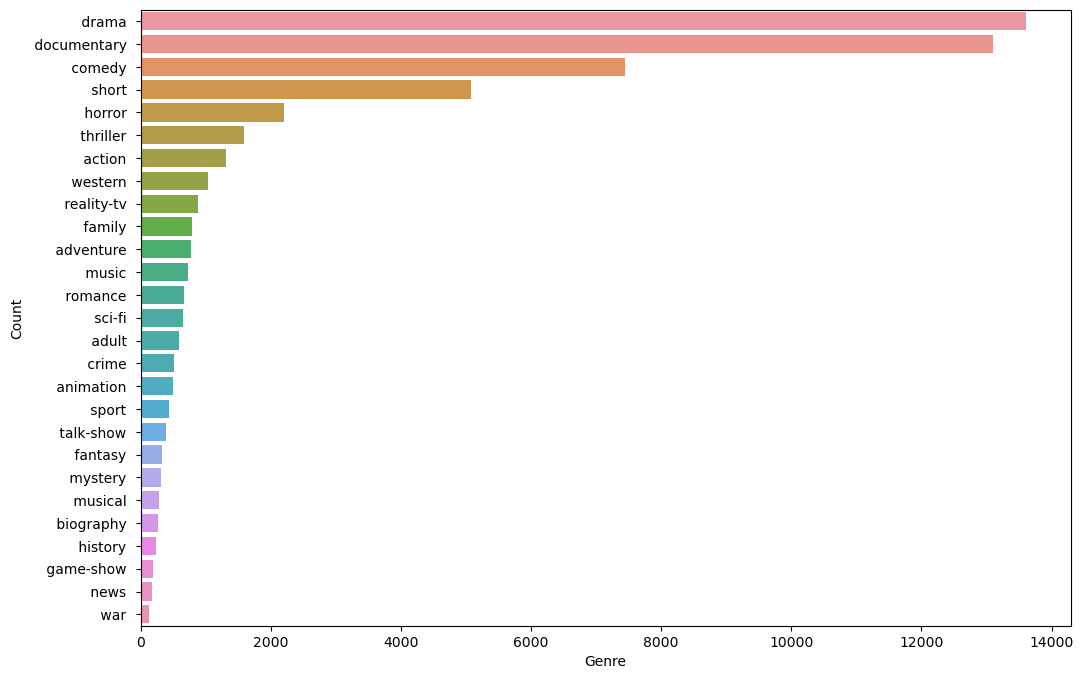

In [12]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts, y=counts.index, orient='h')  
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

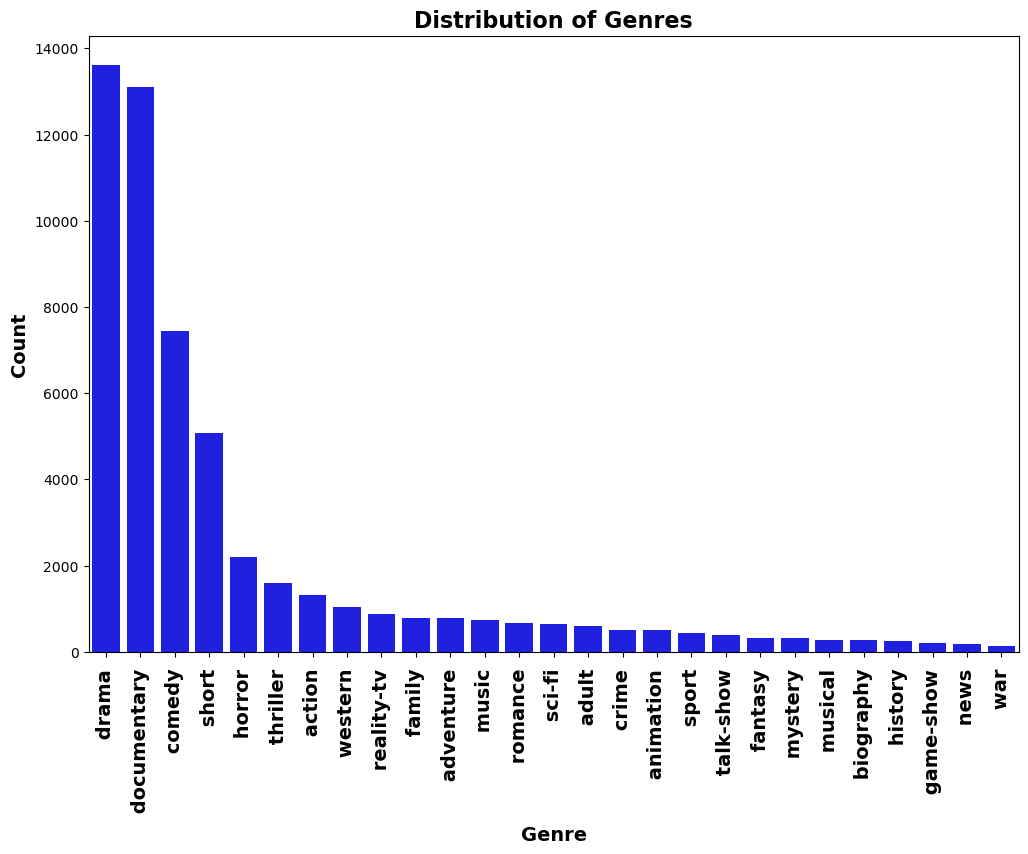

In [13]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts.index, y=counts, color='blue')
plt.xlabel('Genre' ,fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold');

In [14]:
train_data['length']=train_data['Description'].apply(len)
train_data.head()

,Title,Genre,Description,Labeled Genre,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8,625


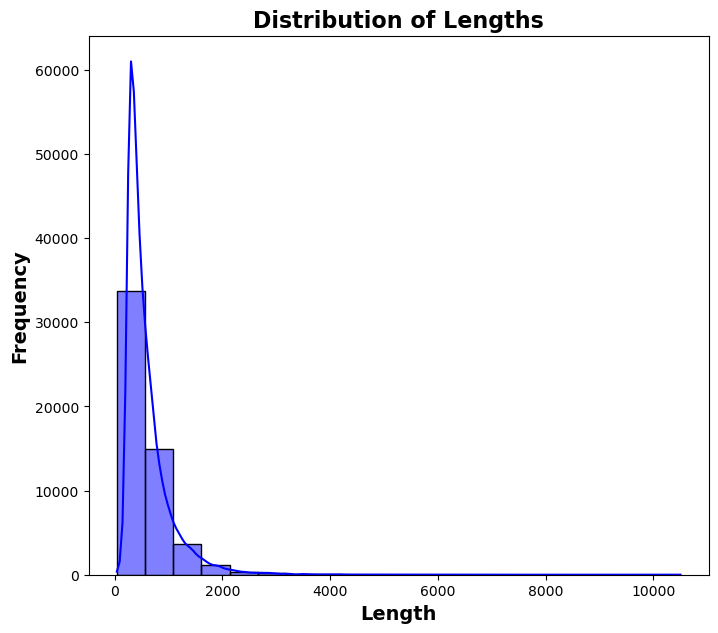

In [15]:
plt.figure(figsize=(8, 7))

sns.histplot(data=train_data, x='length', bins=20, kde=True, color='blue')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

# Performing EDA

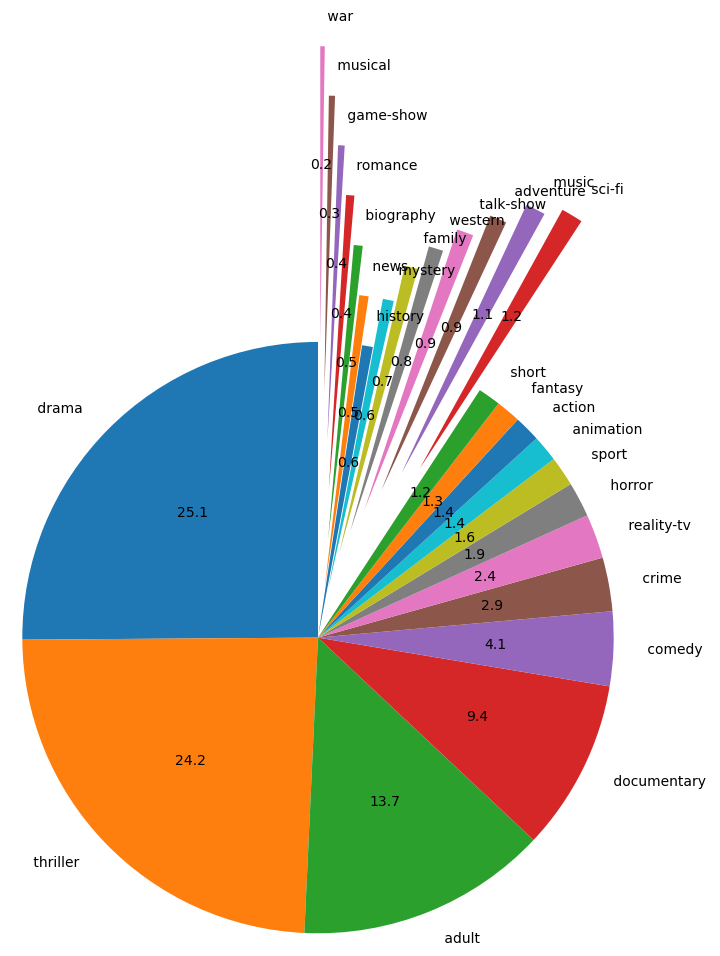

In [16]:
plt.figure(figsize=(8,8))
values = train_data['Genre'].value_counts()
plt.pie(values, labels=output_categories, autopct='%1.1f', startangle=90, radius=1.2, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8, 0.75, 0.65, 0.55, 0.45, 0.35, 0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2))
plt.show()

# Data Cleaning

In [17]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
   
    text = text.lower()                                  # lower-case all characters
    text = re.sub('-',' ',text.lower())   # replace `word-word` as `word word`
    text = re.sub(f'[{string.digits}]',' ',text)  # remove digits
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # remove stopwords and stem other words
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return re.sub(f'[{re.escape(string.punctuation)}]','',text) # remove punctuations


# Test your cleaning function
input_text = "Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38"
print(f'Original text: {input_text}')
print(f'Cleaned text: {clean_text(input_text)}')

Original text: Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38
Cleaned text: certain get dram boost hello bye iem


In [18]:
train_data['Text_cleaning'] = train_data.Description.apply(clean_text)
test_data['Text_cleaning'] = test_data.Description.apply(clean_text)

train_data.head()

,Title,Genre,Description,Labeled Genre,length,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8,625,films titl ref recov body ground zero also sta...


In [19]:
train_data['length_Text_cleaning']=train_data['Text_cleaning'].apply(len)
train_data.head()

,Title,Genre,Description,Labeled Genre,length,Text_cleaning,length_Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8,625,films titl ref recov body ground zero also sta...,282


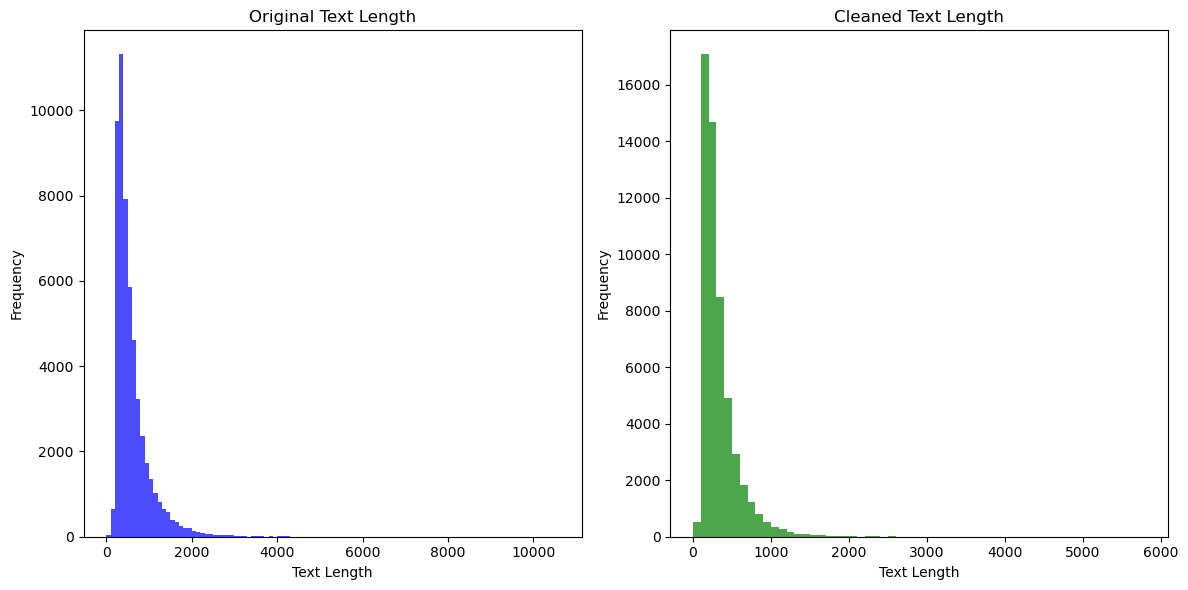

In [20]:
# Create histograms for text length before and after cleaning
plt.figure(figsize=(12, 6))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [21]:
(train_data['length_Text_cleaning']>2000).value_counts()

False    54131
True        83
Name: length_Text_cleaning, dtype: int64

In [22]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(train_data))
filt=train_data['length_Text_cleaning']>2000
train_data.drop(train_data[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  54214
Dataframe size (after removal):  54131
Removed rows: 83


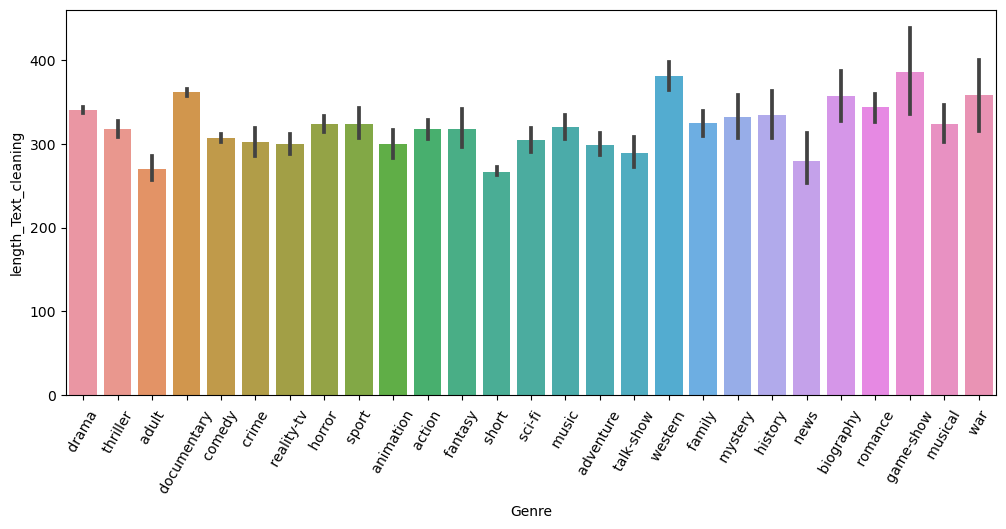

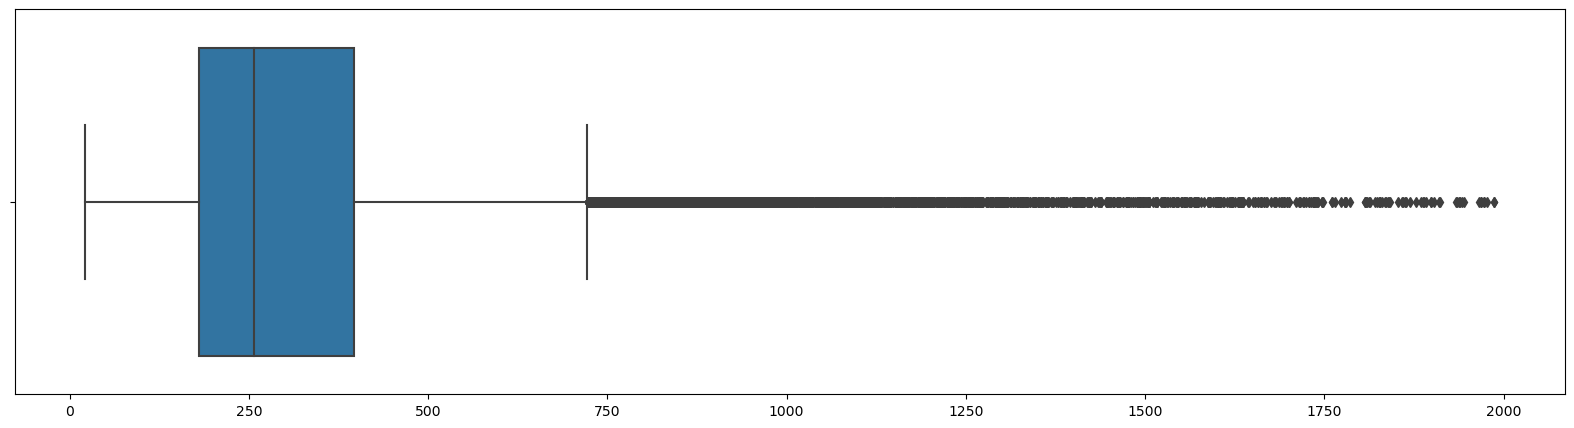

In [23]:
plt.figure(figsize=(12,5))
sns.barplot(x='Genre',y='length_Text_cleaning',data=train_data)  # from 600ish to 350ish -> significant reduction in length
plt.xticks(rotation=60)
plt.show()
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data['length_Text_cleaning'].values,hue='Genre',data=train_data)
plt.show()

# Text Tokenization and Vectorization

In [24]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['Text_cleaning'].values)

In [25]:
test_path= r'C:\Users\Shabi Oye\Desktop\Genre Classification Dataset\test_data.txt'
test_data_solution=pd.read_csv( test_path , sep=':::',engine='python',names=['ID','Title','Genre','Description'])
test_data_solution.head()

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",NaN
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",NaN
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,NaN
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",NaN
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,NaN


# Train the Model

In [30]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [31]:
data = train_data.dropna()
corpus = data["Description"].apply(lambda x: re.findall(r'\w+', x.lower()))
word2vec_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentence):
    words = re.findall(r'\w+', sentence.lower())
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * 100

data["embeddings"] = data["Description"].apply(get_sentence_embedding)
X = pd.DataFrame(data["embeddings"].to_list())

label_encoder = LabelEncoder()
data["genre_encoded"] = label_encoder.fit_transform(data["Genre"])
y = data["genre_encoded"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


predictions = model.predict(X_test)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, predictions))

# Print the confusion matrix
confusion_mat = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(confusion_mat)

Precision: 0.4538320135012684
Recall: 0.48960931005818786
Accuracy: 0.48960931005818786
              precision    recall  f1-score   support

           0       0.43      0.02      0.04       278
           1       0.00      0.00      0.00       118
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       112
           4       0.00      0.00      0.00        71
           5       0.40      0.41      0.40      1500
           6       1.00      0.01      0.02       110
           7       0.56      0.89      0.69      2595
           8       0.45      0.77      0.57      2719
           9       0.62      0.03      0.06       152
          10       0.00      0.00      0.00        71
          11       0.94      0.36      0.52        45
          12       0.00      0.00      0.00        41
          13       0.43      0.09      0.15       440
          14       0.71      0.18      0.28       154
          15       0.00      0.00      0.00    

C:\Users\Shabi Oye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shabi Oye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shabi Oye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shabi Oye\anaconda3\Lib\site-packages\sklearn\m

# Result

As the dataset was very imbalanced so prcision matters more than accuracy. And we see that the LogisticRegression model is performing better than others with 70% precision. So we'll go with that.
